# Debug

In [ ]:
# trying to find a potential bug --> but things look correct

# #!!!
# check that Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked.txt has no redundant ENSP 2 function associations with different Scores
# ENSP = "9606.ENSP00000340944"
# funcName = "GO:0016020" # membrane
# # PTPN11 (ENSP00000340944), is associated with a “Membrane” term with 3 stars.
# # original table
# cond = (df1["ENSP"] == ENSP) & (df1["funcName"] == funcName)
# df1[cond]
# Taxid 	Etype 	ENSP 	funcName 	Score
# 21974650 	9606 	-22 	9606.ENSP00000340944 	GO:0016020 	3.067805
# 21975146 	9606 	-22 	9606.ENSP00000340944 	GO:0016020 	2.145024
# 21975155 	9606 	-22 	9606.ENSP00000340944 	GO:0016020 	2.081105

In [58]:
alternative_2_current_ID_dict = {}
alternative_2_current_ID_dict.update(cst.get_alternative_2_current_ID_dict(GO_obo_Jensenlab, upk=False))
alternative_2_current_ID_dict.update(cst.get_alternative_2_current_ID_dict(GO_obo, upk=False))
# GOCC not needed yet, lineage_dict has GOCC terms but output file has normal GO terms, conversion happens at second backtracking step
alternative_2_current_ID_dict.update(cst.get_alternative_2_current_ID_dict(BTO_obo_Jensenlab, upk=True))
alternative_2_current_ID_dict.update(cst.get_alternative_2_current_ID_dict(DOID_obo_current, upk=True))
DAG = obo_parser.GODag(obo_file=GO_obo_Jensenlab, upk=False)
DAG.load_obo_file(obo_file=DOID_obo_current, upk=True)
DAG.load_obo_file(obo_file=BTO_obo_Jensenlab, upk=True)
# GO_CC_textmining_additional_etype should always be False here --> replaces "GO" with "GOCC". Not necessary yet since, all terms still -22 not -20.
lineage_dict_direct_parents = cst.get_lineage_dict_for_DOID_BTO_GO(GO_obo_Jensenlab, DOID_obo_current, BTO_obo_Jensenlab, GO_CC_textmining_additional_etype=False, direct_parents_only=True)
# backtracking with smart logic to propagate scores

# Imports

In [17]:
pwd

'/scratch/dblyon/agotool/app/python'

In [18]:
cd app/python

[Errno 2] No such file or directory: 'app/python'
/scratch/dblyon/agotool/app/python


In [ ]:
import os, sys
import pandas as pd
import numpy as np
import query
import obo_parser
import create_SQL_tables_snakemake as cst
import tools

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import os, sys, math
from importlib import reload
import random
from itertools import product
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import math

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt


fn_human_ENSPs = r"/mnt/mnemo5/dblyon/agotool/data/PostgreSQL/tables/9606_proteins_ENSPs_STRINGv11.txt"
human_ENSPs = []
with open(fn_human_ENSPs, "r") as fh_in:
    for line in fh_in:
        human_ENSPs.append(line.strip())
human_ENSPs = sorted(human_ENSPs)
d = query.get_Secondary_2_Primary_IDs_dict_from_sec(ids_2_map=human_ENSPs)
human_UniProt_entries = sorted(d.values())

In [48]:
reload(query)
lineage_dict = query.get_lineage_dict_hr()

def which_child_has_this_parent(children, parent, lineage_dict):
    for child in children:
        try:
            all_parents = lineage_dict[child]
        except KeyError:
            print("{} has no lineage #!!!".format(child))
            continue
        if parent in all_parents:
            print("{} has {} as a parent".format(child, parent))

In [ ]:
%matplotlib inline

In [311]:
DOWNLOADS_DIR = r"/scratch/dblyon/agotool/data/PostgreSQL/downloads"
TABLES_DIR = r"/scratch/dblyon/agotool/data/PostgreSQL/tables"
GO_obo_Jensenlab = os.path.join(DOWNLOADS_DIR, "go_Jensenlab.obo")
GO_obo = os.path.join(DOWNLOADS_DIR, "go-basic.obo")
DOID_obo_current = os.path.join(DOWNLOADS_DIR, "DOID_obo_current.obo") # http://purl.obolibrary.org/obo/doid.obo
BTO_obo_Jensenlab = os.path.join(DOWNLOADS_DIR, "bto_Jensenlab.obo")  # static file
Taxid_UniProtID_2_ENSPs_2_KEGGs = os.path.join(TABLES_DIR, "Taxid_UniProtID_2_ENSPs_2_KEGGs.txt")

Protein_2_Function_and_Score_DOID_BTO_GOCC_STS = os.path.join(DOWNLOADS_DIR, "Protein_2_Function_and_Score_DOID_BTO_GOCC_STS.txt.gz")
Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted = os.path.join(TABLES_DIR, "Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted.txt")

Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked = os.path.join(TABLES_DIR, "Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked.txt")
Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked_rescaled = os.path.join(TABLES_DIR, "Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked_rescaled.txt")
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized.txt")
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked.txt")
Protein_2_Function_DOID_BTO_GOCC_UPS = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_UPS.txt")

GO_CC_textmining_additional_etype=True
DAG = obo_parser.GODag(obo_file=GO_obo_Jensenlab, upk=False)
DAG.load_obo_file(obo_file=DOID_obo_current, upk=True)
DAG.load_obo_file(obo_file=BTO_obo_Jensenlab, upk=True)
DAG.load_obo_file(obo_file=GO_obo, upk=False)

lineage_dict_all_parents = cst.get_lineage_dict_for_DOID_BTO_GO(GO_obo_Jensenlab, DOID_obo_current, BTO_obo_Jensenlab, GO_CC_textmining_additional_etype=True, direct_parents_only=False)
secondary_2_primaryTerm_dict, obsolete_terms_set = cst.get_secondary_2_primaryTerm_dict_and_obsolete_terms_set(DAG)
ENSP_2_UniProtID_dict = cst.get_ENSP_2_UniProtID_dict(Taxid_UniProtID_2_ENSPs_2_KEGGs)

In [318]:
!ls -lah {Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked}

-rw-r--r-- 1 dblyon mering 2.1G Mar 18 10:59 /scratch/dblyon/agotool/data/PostgreSQL/tables/Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked.txt


In [315]:
def reformat_TextMining_download(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS, Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted):
    with open(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted, "w") as fh_out:
        fh_out.write("Taxid\tEtype\tENSP\tfuncName\tScore\n")
        for line in tools.yield_line_uncompressed_or_gz_file(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS):
            ENSP, funcName_2_score_arr_str, etype = line.split("\t")
            etype = etype.strip()
            taxid = ENSP.split(".")[0]
            funcName_2_score_list_temp = cst.helper_convert_str_arr_2_nested_list(funcName_2_score_arr_str)
            for funcName, score in funcName_2_score_list_temp:
                fh_out.write("{}\t{}\t{}\t{}\t{}\n".format(taxid, etype, ENSP, funcName, score))
reformat_TextMining_download(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS, Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted)                

In [56]:
# !zgrep -P "^9606." {Protein_2_Function_and_Score_DOID_BTO_GOCC_STS} | grep "GO:0016020"

In [319]:
# use backtracked and rescaled scores 
df1 = pd.read_csv(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked, sep='\t')
df1 = df1[df1["ENSP"].isin(human_ENSPs)] 
df1.head(3)

,Taxid,Etype,ENSP,funcName,Score
5716626,9606,-26,9606.ENSP00000000233,DOID:0014667,8.9e-01
5716627,9606,-26,9606.ENSP00000000233,DOID:0050013,6.5e-01
5716628,9606,-26,9606.ENSP00000000233,DOID:0050117,8.3e-01


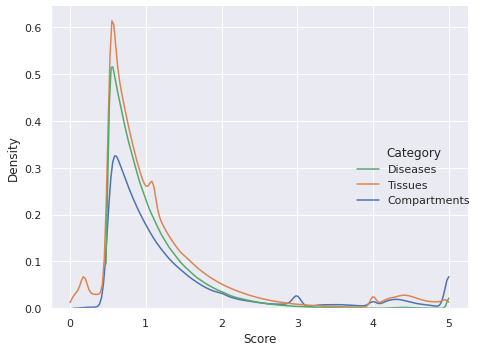

In [320]:
df1["Category"] = ""
df1.loc[df1["Etype"] == -22, "Category"] = "Compartments"
df1.loc[df1["Etype"] == -25, "Category"] = "Tissues"
df1.loc[df1["Etype"] == -26, "Category"] = "Diseases"
unique = ["Compartments", "Tissues", "Diseases"]
sns_plot = sns.displot(df1, x="Score", kind="kde", hue="Category", cut=True, clip=(0, 5), palette=dict(zip(unique, sns.color_palette(n_colors=len(unique)))))
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Score_KDE.pdf")

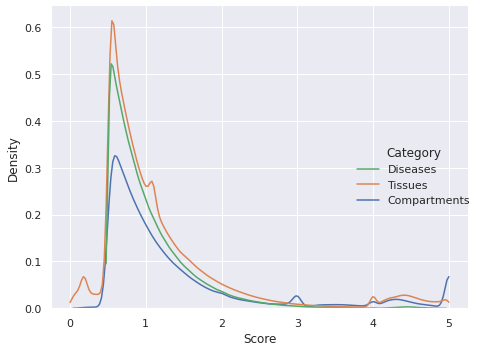

In [272]:
df1["Category"] = ""
df1.loc[df1["Etype"] == -22, "Category"] = "Compartments"
df1.loc[df1["Etype"] == -25, "Category"] = "Tissues"
df1.loc[df1["Etype"] == -26, "Category"] = "Diseases"
unique = ["Compartments", "Tissues", "Diseases"]
sns_plot = sns.displot(df1, x="Score", kind="kde", hue="Category", cut=True, clip=(0, 5), palette=dict(zip(unique, sns.color_palette(n_colors=len(unique)))))
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Score_KDE.pdf")

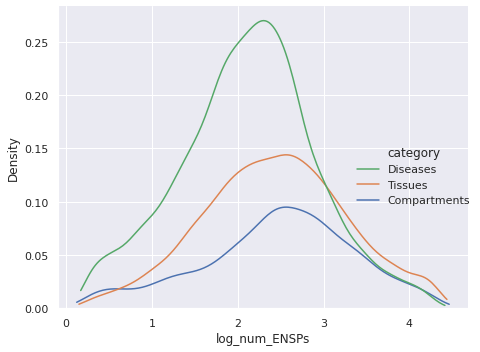

In [321]:
dfx = df1.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df1[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-22: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
unique = ["Compartments", "Tissues", "Diseases"]
sns_plot = sns.displot(dfx, x="log_num_ENSPs", kind="kde", hue="category", cut=True, clip=(0, 10), palette=dict(zip(unique, sns.color_palette(n_colors=len(unique)))))
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Log10_TermSize.pdf")

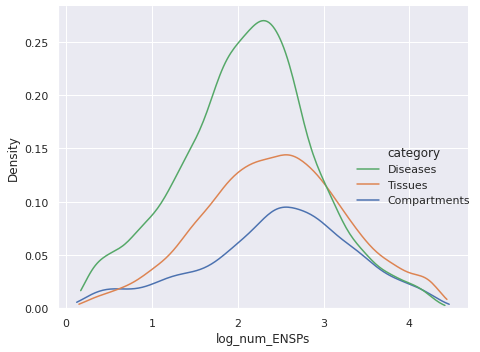

In [271]:
dfx = df1.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df1[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-22: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
unique = ["Compartments", "Tissues", "Diseases"]
sns_plot = sns.displot(dfx, x="log_num_ENSPs", kind="kde", hue="category", cut=True, clip=(0, 10), palette=dict(zip(unique, sns.color_palette(n_colors=len(unique)))))
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Log10_TermSize.pdf")

In [7]:
!head {Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked_rescaled}

Taxid	Etype	ENSP	funcName	Score	Rescaled_score_orig	Rescaled_score
3702	-22	3702.AT2G24590.1	GO:0000015	0.500583	6.782187300813343	6.782187300813343
3702	-22	3702.AT4G37320.1	GO:0000015	0.501915	6.775931033949791	6.771022715555246
3702	-22	3702.AT4G37330.1	GO:0000015	0.501915	6.771022715555246	6.771022715555246
3702	-22	3702.AT4G37360.1	GO:0000015	0.501915	6.766106996232608	6.771022715555246
3702	-22	3702.AT1G72040.1	GO:0000015	0.502487	6.760603479686604	6.760603479686604
3702	-22	3702.AT5G41670.2	GO:0000015	0.509259	6.748805409514388	6.748805409514388
3702	-22	3702.AT2G44100.1	GO:0000015	0.510437	6.742678613627896	6.742678613627896
3702	-22	3702.AT3G54050.1	GO:0000015	0.51049	6.737685648331268	6.737685648331268
3702	-22	3702.AT2G31390.1	GO:0000015	0.510633	6.732594124940976	6.732594124940976


In [153]:
from importlib import reload
reload(cst)

<module 'create_SQL_tables_snakemake' from '/scratch/dblyon/agotool/app/python/create_SQL_tables_snakemake.py'>

# Compartments

In [322]:
### GOCC from UniProt, in UniProt Entry Names, reduced to 
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/Function_2_Protein_table_9606_UPS_temp_TM_discretization_comparison_v2.txt" 
term_l, uniproten_l = [], []
with open(fn_out, "r") as fh:
    for line in fh:
        term, uniproten, etype = line.strip().split("\t")
        if etype == "-22":
            term_l.append(term)
            uniproten_l.append(uniproten)
            
GOCC_uniprot_function_l = []
for uniprot, term in zip(uniproten_l, term_l):
    GOCC_uniprot_function_l.append(uniprot + "_" + term)
print(len(GOCC_uniprot_function_l), len(set(GOCC_uniprot_function_l)))
GOCC_uniprot_function_set = set(GOCC_uniprot_function_l)

348647 348647


(221883, 8)  backtracked and rescaled scores
(150963, 8)  Score of 5


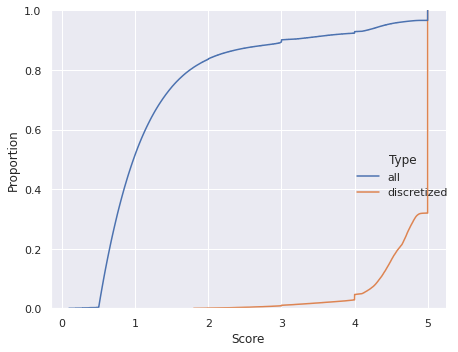

In [364]:
etype = -22
alpha = 0.2
beta = 0.7
### seems good
# alpha_22 = 0.325,
# beta_22 = 1.65,

### use backtracked and rescaled scores --> discretize and backtrack again
df_22 = cst.rescale_scores(df1[df1["Etype"] == etype], alpha=alpha)
df_22 = df_22[(df_22["Score"] >= 1.5) & (df_22["Rescaled_score"] <= beta)]
print(df_22.shape, " backtracked and rescaled scores")
print(df_22[df_22["Score"] == 5].shape, " Score of 5")

###### before final backtracking
### Score ECDF proportion
x1 = df1.loc[df1["Etype"] == etype, "Score"].to_list()
x2 = df_22["Score"].to_list()
x = pd.DataFrame()
x["Score"] = x1 + x2
x["Type"] = len(x1)*["all"] + len(x2)*["discretized"]
sns_plot = sns.displot(x, x="Score", kind="ecdf", hue="Type")
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_ECDF_Score_all_vs_discretized_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta))

### backtracking
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
Protein_2_Function_DOID_BTO_GOCC_UPS_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_UPS_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
DOID_BTO_GOCC_without_lineage_etype = os.path.join(TABLES_DIR, "DOID_BTO_GOCC_without_lineage_{}_temp.txt".format(etype))
cst.backtrack_funcNames(df_22, lineage_dict_all_parents, secondary_2_primaryTerm_dict, obsolete_terms_set, ENSP_2_UniProtID_dict, Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, Protein_2_Function_DOID_BTO_GOCC_UPS_etype, DOID_BTO_GOCC_without_lineage_etype, GO_CC_textmining_additional_etype=True)

355398  total_num_associations
3183  num unique Compartments


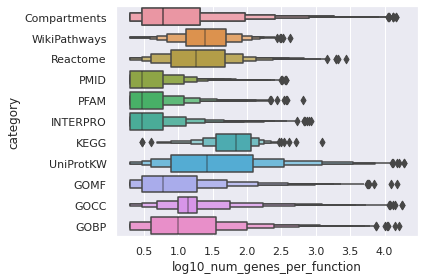

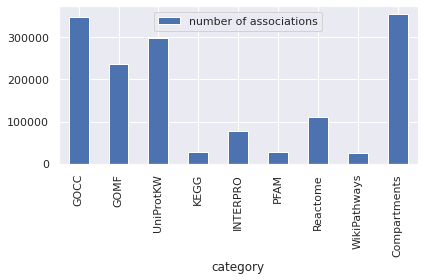

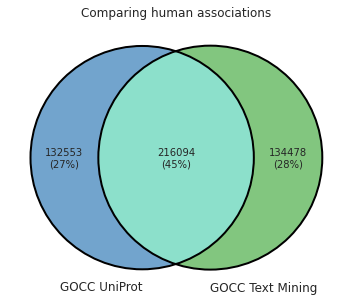

In [350]:
##### after final backtracking
### Size of terms
dft = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = dft[dft["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique Compartments")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
ax = sns.boxenplot(data=dfx, orient="h", x="log_num_ENSPs", y="category")
fn = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/Function_2_Protein_table_9606_UPS_temp_TM_discretization_comparison_counts.txt"
df2m = pd.read_csv(fn, sep='\t')
cond = df2m["num_UniProtEN"] < 2
df2m = df2m[~cond]
cond_2_exclude = df2m["etype"].isin({-20, -25, -26})
df2m = df2m[~cond_2_exclude]
df2m = df2m.rename(columns={"etype": "Etype", "log_num_UniProtEN": "log10_num_genes_per_function"})
dfx = dfx.rename(columns={"log_num_ENSPs": "log10_num_genes_per_function"})
dfm = pd.concat([dfx[["Etype", "category", "log10_num_genes_per_function"]], df2m[["Etype", "category", "log10_num_genes_per_function"]]])
ax = sns.boxenplot(data=dfm, orient="h", x="log10_num_genes_per_function", y="category")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Boxenplot_TermSize_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
ax.get_figure().savefig(fn_out)

### Number of associations (compared to other categories)
d = {# "GOBP": 1191825, 
"GOCC": 348647,
"GOMF": 237452,
"UniProtKW": 297363,
"KEGG": 27998,
"INTERPRO": 78688,
"PFAM": 28129,
# "PMID": 22143978,
"Reactome": 111639,
"WikiPathways": 26100}
d["Compartments"] = total_num_associations
df = pd.DataFrame()
df["category"] = d.keys()
df["number of associations"] = d.values()
df["log10"] = df["number of associations"].apply(lambda x: np.log10(x))
df.plot.bar(x="category", y="number of associations")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Barplot_TotalNumberAssociations_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
plt.savefig(fn_out)

### Term size of associations (compared to other categories)
GOCC_TM_uniprot_function_l = []
with open(Protein_2_Function_DOID_BTO_GOCC_UPS_etype, "r") as fh:
    for line in fh:
        if line.startswith("9606\t") and line.endswith("-20\n"):
            taxid, uniproten, func_arr, etype = line.strip().split("\t")
            for func in func_arr[1:-1].replace('"', "").replace("GOCC:", "GO:").split(","):
                GOCC_TM_uniprot_function_l.append(uniproten + "_" + func)
GOCC_TM_uniprot_function_set = set(GOCC_TM_uniprot_function_l)
# Overlap with GOCC
a = GOCC_uniprot_function_set
b = GOCC_TM_uniprot_function_set
left = len(a - b)
right = len(b - a)
intersection = len(a.intersection(b))
total = len(a.union(b))
plt.figure(figsize=(5, 5))
v = venn2(subsets = (left, right, intersection), set_labels = ("GOCC UniProt", "GOCC Text Mining"), set_colors=('#377eb8', '#4daf4a'), 
          alpha = 0.7, subset_label_formatter = lambda x: str(x) + "\n(" + f"{(x/total):1.0%}" + ")")
venn2_circles(subsets = (left, right, intersection))
plt.title("Comparing human associations")
plt.savefig("/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Venn_diagram_GOCC_UniProt_vs_TextMining_alpha_{}_beta_{}.pdf".format(alpha, beta))

# Tissues

(173014, 8)  backtracked and rescaled scores
(1605, 8)  Score of 5


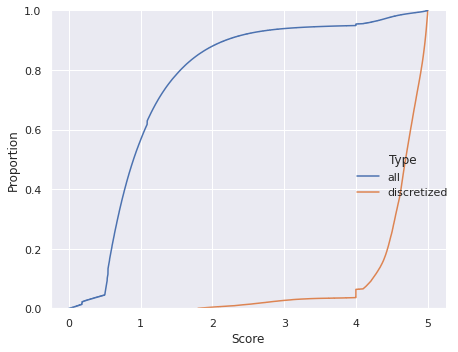

In [363]:
etype = -25
alpha = 0.2
beta = 0.7
# alpha_25 = 0.3,
# beta_25 = 1.4,

### use backtracked and rescaled scores --> discretize and backtrack again
df_22 = cst.rescale_scores(df1[df1["Etype"] == etype], alpha=alpha)
df_22 = df_22[(df_22["Score"] >= 1.5) & (df_22["Rescaled_score"] <= beta)]
print(df_22.shape, " backtracked and rescaled scores")
print(df_22[df_22["Score"] == 5].shape, " Score of 5")

###### before final backtracking
### Score ECDF proportion
x1 = df1.loc[df1["Etype"] == etype, "Score"].to_list()
x2 = df_22["Score"].to_list()
x = pd.DataFrame()
x["Score"] = x1 + x2
x["Type"] = len(x1)*["all"] + len(x2)*["discretized"]
sns_plot = sns.displot(x, x="Score", kind="ecdf", hue="Type")
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_ECDF_Score_all_vs_discretized_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta))

### backtracking
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
Protein_2_Function_DOID_BTO_GOCC_UPS_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_UPS_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
DOID_BTO_GOCC_without_lineage_etype = os.path.join(TABLES_DIR, "DOID_BTO_GOCC_without_lineage_{}_temp.txt".format(etype))
cst.backtrack_funcNames(df_22, lineage_dict_all_parents, secondary_2_primaryTerm_dict, obsolete_terms_set, ENSP_2_UniProtID_dict, Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, Protein_2_Function_DOID_BTO_GOCC_UPS_etype, DOID_BTO_GOCC_without_lineage_etype, GO_CC_textmining_additional_etype=True)

258384  total_num_associations
3894  num unique Tissues


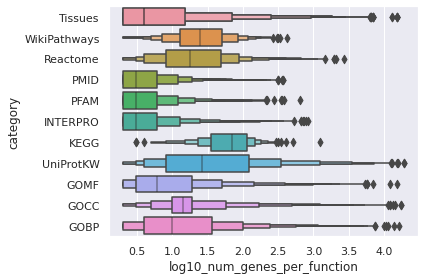

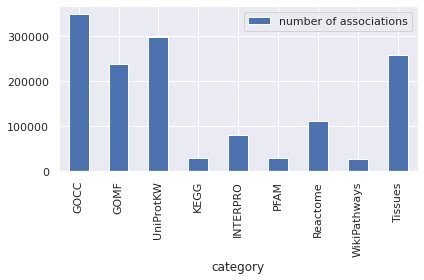

In [352]:
##### after final backtracking
### Size of terms
dft = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = dft[dft["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique Tissues")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
ax = sns.boxenplot(data=dfx, orient="h", x="log_num_ENSPs", y="category")
fn = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/Function_2_Protein_table_9606_UPS_temp_TM_discretization_comparison_counts.txt"
df2m = pd.read_csv(fn, sep='\t')
cond = df2m["num_UniProtEN"] < 2
df2m = df2m[~cond]
cond_2_exclude = df2m["etype"].isin({-20, -25, -26})
df2m = df2m[~cond_2_exclude]
df2m = df2m.rename(columns={"etype": "Etype", "log_num_UniProtEN": "log10_num_genes_per_function"})
dfx = dfx.rename(columns={"log_num_ENSPs": "log10_num_genes_per_function"})
dfm = pd.concat([dfx[["Etype", "category", "log10_num_genes_per_function"]], df2m[["Etype", "category", "log10_num_genes_per_function"]]])
ax = sns.boxenplot(data=dfm, orient="h", x="log10_num_genes_per_function", y="category")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Boxenplot_TermSize_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
ax.get_figure().savefig(fn_out)

### Number of associations (compared to other categories)
d = {# "GOBP": 1191825, 
"GOCC": 348647,
"GOMF": 237452,
"UniProtKW": 297363,
"KEGG": 27998,
"INTERPRO": 78688,
"PFAM": 28129,
# "PMID": 22143978,
"Reactome": 111639,
"WikiPathways": 26100}
d["Tissues"] = total_num_associations
df = pd.DataFrame()
df["category"] = d.keys()
df["number of associations"] = d.values()
df["log10"] = df["number of associations"].apply(lambda x: np.log10(x))
df.plot.bar(x="category", y="number of associations")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Barplot_TotalNumberAssociations_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
plt.savefig(fn_out)

# Diseases

(46831, 8)  backtracked and rescaled scores
(23953, 8)  Score of 5


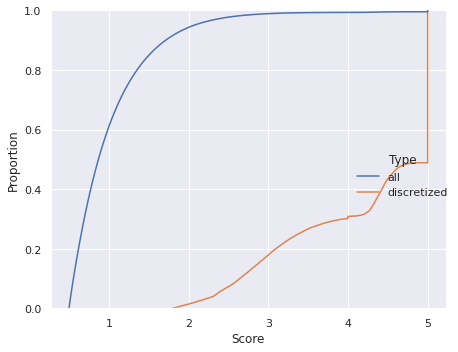

In [362]:
etype = -26
alpha = 0.2
beta = 0.7
# alpha = 0.15
# beta = 0.75
# alpha = 0.17
# beta = 0.75
# alpha = 0.15
# beta = 0.75
# alpha = 0.175
# beta = 0.8
# alpha = 0.2
# beta = 0.8
# alpha = 0.3
# beta = 1.0

### use backtracked and rescaled scores --> discretize and backtrack again
df_22 = cst.rescale_scores(df1[df1["Etype"] == etype], alpha=alpha)
df_22 = df_22[(df_22["Score"] >= 1.5) & (df_22["Rescaled_score"] <= beta)]
print(df_22.shape, " backtracked and rescaled scores")
print(df_22[df_22["Score"] == 5].shape, " Score of 5")

###### before final backtracking
### Score ECDF proportion
x1 = df1.loc[df1["Etype"] == etype, "Score"].to_list()
x2 = df_22["Score"].to_list()
x = pd.DataFrame()
x["Score"] = x1 + x2
x["Type"] = len(x1)*["all"] + len(x2)*["discretized"]
sns_plot = sns.displot(x, x="Score", kind="ecdf", hue="Type")
sns_plot.savefig(r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_ECDF_Score_all_vs_discretized_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta))

### backtracking
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
Protein_2_Function_DOID_BTO_GOCC_UPS_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_UPS_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
DOID_BTO_GOCC_without_lineage_etype = os.path.join(TABLES_DIR, "DOID_BTO_GOCC_without_lineage_{}_temp.txt".format(etype))
cst.backtrack_funcNames(df_22, lineage_dict_all_parents, secondary_2_primaryTerm_dict, obsolete_terms_set, ENSP_2_UniProtID_dict, Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, Protein_2_Function_DOID_BTO_GOCC_UPS_etype, DOID_BTO_GOCC_without_lineage_etype, GO_CC_textmining_additional_etype=True)

87895  total_num_associations
7463  num unique diseases


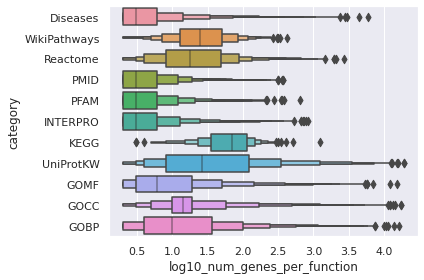

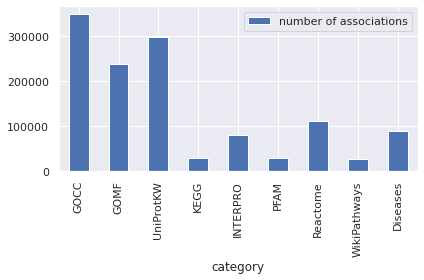

In [354]:
##### after final backtracking
### Size of terms
dft = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = dft[dft["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique diseases")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
# ax = sns.boxenplot(data=dfx, orient="h", x="log_num_ENSPs", y="category")  --> not shown, since included in comparison with other etypes
fn = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/Function_2_Protein_table_9606_UPS_temp_TM_discretization_comparison_counts.txt"
df2m = pd.read_csv(fn, sep='\t')
cond = df2m["num_UniProtEN"] < 2
df2m = df2m[~cond]
cond_2_exclude = df2m["etype"].isin({-20, -25, -26})
df2m = df2m[~cond_2_exclude]
df2m = df2m.rename(columns={"etype": "Etype", "log_num_UniProtEN": "log10_num_genes_per_function"})
dfx = dfx.rename(columns={"log_num_ENSPs": "log10_num_genes_per_function"})
dfm = pd.concat([dfx[["Etype", "category", "log10_num_genes_per_function"]], df2m[["Etype", "category", "log10_num_genes_per_function"]]])
ax = sns.boxenplot(data=dfm, orient="h", x="log10_num_genes_per_function", y="category")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Boxenplot_TermSize_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
ax.get_figure().savefig(fn_out)

### Number of associations (compared to other categories)
d = {# "GOBP": 1191825, 
"GOCC": 348647,
"GOMF": 237452,
"UniProtKW": 297363,
"KEGG": 27998,
"INTERPRO": 78688,
"PFAM": 28129,
# "PMID": 22143978,
"Reactome": 111639,
"WikiPathways": 26100}
d["Diseases"] = total_num_associations
df = pd.DataFrame()
df["category"] = d.keys()
df["number of associations"] = d.values()
df["log10"] = df["number of associations"].apply(lambda x: np.log10(x))
df.plot.bar(x="category", y="number of associations")
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Barplot_TotalNumberAssociations_comparison_etype_{}_alpha_{}_beta_{}.pdf".format(etype, alpha, beta)
plt.savefig(fn_out)

# Summary

## Number of associations after each step

In [356]:
# !ls -lah {Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted}
# !head {Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted}

In [357]:
df = pd.read_csv(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted, sep='\t') #, names=["Taxid", "Etype", "ENSP", "funcName", "Score"])
df = df[df["ENSP"].isin(human_ENSPs)]
df.groupby("Etype")["ENSP"].count()
# -26    4542678
# -25    6721335
# -22    3709558

Etype
-26    4542678
-25    6721335
-22    3709558
Name: ENSP, dtype: int64

In [361]:
df = pd.read_csv(Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked, sep='\t')
df = df[df["ENSP"].isin(human_ENSPs)]
df.groupby("Etype")["ENSP"].count()
# -26    5344975
# -25    7117392
# -22    4510937

Etype
-26    5344975
-25    7117392
-22    4510937
Name: ENSP, dtype: int64

In [359]:
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized, sep='\t')
df = df[df["ENSP"].isin(human_ENSPs)]
df.groupby("Etype")["ENSP"].count()
# -26     67188
# -25    156394
# -22    212275

Etype
-26     67188
-25    156394
-22    212275
Name: ENSP, dtype: int64

In [360]:
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked, sep='\t')
df = df[df["ENSP"].isin(human_ENSPs)]
df.groupby("Etype")["ENSP"].count()
# -26    131165
# -25    251709
# -20    423365

Etype
-26    135252
-25    251709
-20    423365
Name: ENSP, dtype: int64

In [252]:
### Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_reformatted Taxid 9606 (before backtracking)
# Etype
# -26    4541099
# -25    6720383
# -22    3709147
### --> Score of 5
# -25      1605
# -22    122656

### Protein_2_Function_and_Score_DOID_BTO_GOCC_STS_backtracked Taxid 9606 (after 1. backtracking)
# Etype
# -26    5344821
# -25    7117392
# -22    4510937

### Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized Taxid 9606 (after discretization)
# Etype
# -26     55991
# -25    156394
# -22    212275

### Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked Taxid 9606 (after second backtracking), final
# Etype
# -26    131165
# -25    251709
# -20    423365

step = ["unmodified source", "1. backtracking", "discretization", "2. backtracking"]
# reducing to ENSPs in STRING 11 (Taxid 9606 only)
e26 = [4541099, 5344821, 55991, 131165]
e25 = [6720383, 7117392, 156394, 251709]
e22 = [3709147, 4510937, 212275, 423365]
df = pd.DataFrame()
df["step"] = step
df["Compartments"] = e22
df["Diseases"] = e26
df["Tissues"] = e25
df = df.set_index("step")
df["Compartments"] = df["Compartments"].astype("float")
df["Diseases"] = df["Diseases"].astype("float")
df["Tissues"] = df["Tissues"].astype("float")
pd.options.display.float_format = '{:.1e}'.format
# pd.reset_option('^display.', silent=True)
df

,Compartments,Diseases,Tissues
step,,,
unmodified source,3.7e+06,4.5e+06,6.7e+06
1. backtracking,4.5e+06,5.3e+06,7.1e+06
discretization,2.1e+05,5.6e+04,1.6e+05
2. backtracking,4.2e+05,1.3e+05,2.5e+05


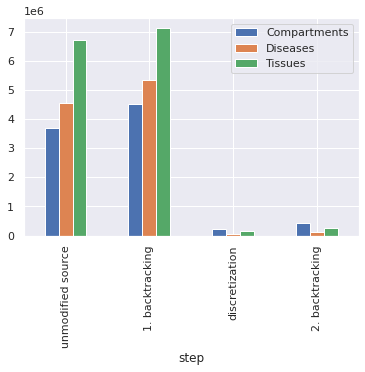

In [253]:
ax = df.plot.bar()
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Barplot_number_associations_after_each_step.pdf"
# plt.savefig(fn_out)
fig = ax.get_figure()
fig.savefig(fn_out)

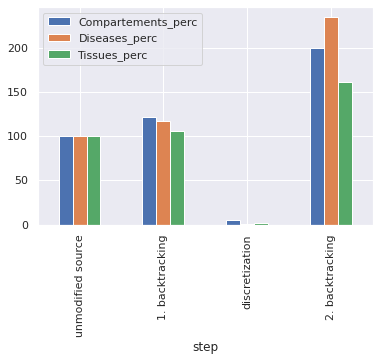

In [249]:
vals = 100* np.append(df["Compartments"].values[1:], df["Compartments"].values[-1]) / df["Compartments"].values
df["Compartements_perc"] = np.append(vals[-1], vals[:-1])
vals = 100* np.append(df["Diseases"].values[1:], df["Diseases"].values[-1]) / df["Diseases"].values
df["Diseases_perc"] = np.append(vals[-1], vals[:-1])
vals = 100* np.append(df["Tissues"].values[1:], df["Tissues"].values[-1]) / df["Tissues"].values
df["Tissues_perc"] = np.append(vals[-1], vals[:-1])
df[['Compartements_perc', 'Diseases_perc', 'Tissues_perc']].plot.bar()
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Barplot_number_associations_after_each_step_in_percent_relative_to_previous_step.pdf"
plt.savefig(fn_out)

In [250]:
df

,Compartments,Diseases,Tissues,Compartements_perc,Diseases_perc,Tissues_perc
step,,,,,,
unmodified source,3.7e+06,4.5e+06,6.7e+06,1.0e+02,1.0e+02,1.0e+02
1. backtracking,4.5e+06,5.3e+06,7.1e+06,1.2e+02,1.2e+02,1.1e+02
discretization,2.1e+05,5.6e+04,1.6e+05,4.7e+00,1.0e+00,2.2e+00
2. backtracking,4.2e+05,1.3e+05,2.5e+05,2.0e+02,2.3e+02,1.6e+02


In [246]:
pd.reset_option('^display.', silent=True)
df

,Compartments,Diseases,Tissues,Compartements_perc,Diseases_perc,Tissues_perc
step,,,,,,
unmodified source,3709147.0,4541099.0,6720383.0,100.000000,100.000000,100.000000
1. backtracking,4510937.0,5344821.0,7117392.0,121.616560,117.698843,105.907535
discretization,212275.0,55991.0,156394.0,4.705785,1.047575,2.197350
2. backtracking,423365.0,131165.0,251709.0,199.441762,234.260863,160.945433


## Ggplot number comparison

In [280]:
# Function_2_Protein_table_UPS = os.path.join(TABLES_DIR, "Function_2_Protein_table_UPS.txt")
# Function_2_Protein_table_9606_temp = os.path.join(TABLES_DIR, "Function_2_Protein_table_9606_temp.txt")
# temp_9606_Number_of_proteins_per_function
Protein_2_Function_table_UPS = os.path.join(TABLES_DIR, "Protein_2_Function_table_UPS.txt")
Protein_2_Function_table_UPS_9606_temp = os.path.join(TABLES_DIR, "Protein_2_Function_table_UPS_9606_temp.txt")
Protein_2_Function_table_UPS_9606_subset_STRING_v11_temp = os.path.join(TABLES_DIR, "Protein_2_Function_table_UPS_9606_subset_STRING_v11_temp.txt")

In [277]:
# !grep -P "^9606\t" {Function_2_Protein_table_UPS} > {Function_2_Protein_table_9606_temp}
### grep human proteins

^C


In [281]:
!grep -P "^9606\t" {Protein_2_Function_table_UPS} > {Protein_2_Function_table_UPS_9606_temp}

In [278]:
### reduce to human_UniProt_entries
human_UniProt_entries[:3]

['1433B_HUMAN', '1433E_HUMAN', '1433F_HUMAN']

In [279]:
!head {Protein_2_Function_table_UPS_9606_temp}

In [284]:
from collections import defaultdict

In [309]:
etype_2_count_dict = defaultdict(int)
with open(Protein_2_Function_table_UPS_9606_temp, "r") as fh_in:
    for line in fh_in:
        taxid, uniproten, funcarr, etype = line.strip().split("\t")
        if uniproten not in human_UniProt_entries:
            continue
        etype_2_count_dict[etype] += funcarr.count(",") + 1

In [310]:
etype_2_count_dict

defaultdict(int,
            {'-25': 248806,
             '-21': 1191825,
             '-23': 237452,
             '-22': 348647,
             '-20': 417307,
             '-57': 111639,
             '-54': 78688,
             '-51': 297363,
             '-55': 28129,
             '-56': 22210473,
             '-58': 26494,
             '-52': 27998,
             '-26': 129730})

In [ ]:
functionType_2_entityType_dict = {"Gene Ontology cellular component TEXTMINING": -20,
                                  "Gene Ontology biological process": -21,
                                  "Gene Ontology cellular component": -22,
                                  "Gene Ontology molecular function": -23,
                                  "Brenda Tissue Ontology": -25,
                                  "Disease Ontology": -26,
                                  "UniProt keywords": -51,
                                  "KEGG (Kyoto Encyclopedia of Genes and Genomes)": -52,
                                  "SMART (Simple Modular Architecture Research Tool)": -53,
                                  "INTERPRO": -54,
                                  "PFAM (Protein FAMilies)": -55,
                                  "PMID": -56,
                                  "Reactome": -57,
                                  "WikiPathways": -58}

In [ ]:
library(ggplot2)
library(ggforce)
## ggplot Barplot number of associations
df <- data.frame(category = c('Compartments', 'Tissues', 'Diseases', 
                              'GOBP', 'GOCC', 'GOMF', 
                              'UniProtKW', 'KEGG', 'INTERPRO', 
                              'PFAM', 'PMID', 'Reactome', 
                              'WikiPathways'),
                 num_associations = c(417307, 248806, 129730,
                                      1191825, 348647, 237452, 
                                      297363, 27998, 78688, 
                                      28129, 22210473, 111639, 
                                      26494))
p <- ggplot(df) + 
  aes(x = reorder(category, num_associations), y = num_associations, fill = reorder(category, num_associations)) +
  geom_bar(stat="identity") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
  facet_zoom(ylim = c(0, 450000))
p    
ggsave("/Users/dblyon/modules/cpr/agotool/data/PostgreSQL/tables/plots/Barplot_num_associations_of_all_categories_including_TM_discretization_9606_STRINGv11_2p_v3.pdf")

## Term size comparison

In [222]:
etype = -22
alpha = 0.325
beta = 1.65
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df.head()

,Taxid,Etype,ENSP,funcName
0,9606,-20,9606.ENSP00000000412,GOCC:0031984
1,9606,-20,9606.ENSP00000000412,GOCC:0043227
2,9606,-20,9606.ENSP00000000412,GOCC:0005765
3,9606,-20,9606.ENSP00000000412,GOCC:0030135
4,9606,-20,9606.ENSP00000000412,GOCC:0043229


In [254]:
etype = -22
alpha = 0.325
beta = 1.65
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = df[df["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique diseases")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
df_22 = dfx[["Etype", "category", "log_num_ENSPs"]]


etype = -25
alpha = 0.3
beta = 1.4
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = df[df["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique diseases")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
df_25 = dfx[["Etype", "category", "log_num_ENSPs"]]
            

etype = -26
alpha = 0.15
beta = 0.75
Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype = os.path.join(TABLES_DIR, "Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype_{}_alpha_{}_beta_{}.txt".format(etype, alpha, beta))
df = pd.read_csv(Protein_2_Function_DOID_BTO_GOCC_STS_backtracked_discretized_backtracked_etype, sep="\t")
df = df[df["ENSP"].isin(human_ENSPs)]
total_num_associations = df.shape[0]
print(total_num_associations, " total_num_associations")
print(len(df["funcName"].unique()), " num unique diseases")
dfx = df.groupby("funcName")["ENSP"].count().reset_index().rename(columns={"ENSP": "num_ENSPs"})
dfx["log_num_ENSPs"] = dfx["num_ENSPs"].apply(lambda x: np.log10(x))
funcName_2_logNumENSPs_dict = {funcName_logENSPs[0]: funcName_logENSPs[1] for funcName_logENSPs in zip(dfx["funcName"].values, dfx["log_num_ENSPs"].values)}
dfx = df[["Etype", "funcName"]].drop_duplicates()
dfx["log_num_ENSPs"] = dfx["funcName"].apply(lambda x: funcName_2_logNumENSPs_dict[x])
dfx = dfx[dfx["log_num_ENSPs"] > 0] # more than 1 function per protein per genome
entityType_2_functionType_dict = {-20: "Compartments",
                                  -25: "Tissues",
                                  -26: "Diseases",}
dfx["category"] = dfx["Etype"].apply(lambda x: entityType_2_functionType_dict[x])
df_26 = dfx[["Etype", "category", "log_num_ENSPs"]]

414255  total_num_associations
3308  num unique diseases
328061  total_num_associations
4809  num unique diseases
132420  total_num_associations
8142  num unique diseases


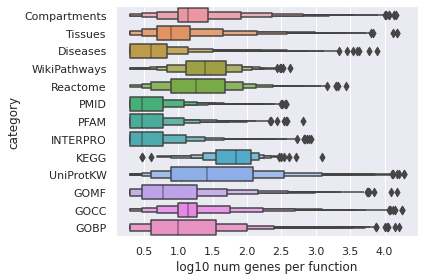

<Figure size 1440x432 with 0 Axes>

In [258]:
fn = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/Function_2_Protein_table_9606_UPS_temp_TM_discretization_comparison_counts.txt"
df2m = pd.read_csv(fn, sep='\t')
cond = df2m["num_UniProtEN"] < 2
df2m = df2m[~cond]
cond_2_exclude = df2m["etype"].isin({-20, -25, -26})
df2m = df2m[~cond_2_exclude]
df2m = df2m.rename(columns={"etype": "Etype", "log_num_UniProtEN": "log_num_ENSPs"})
df2m = df2m[["Etype", "category", "log_num_ENSPs"]]
dfm = pd.concat([df_22, df_25, df_26, df2m])
dfm = dfm.rename(columns={"log_num_ENSPs": "log10 num genes per function"})
ax = sns.boxenplot(data=dfm, orient="h", x="log10 num genes per function", y="category")
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'figure.subplot.left': 0.1})
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Boxenplot_Comparison_TextMining_vs_rest_log10_num_genes_per_function_v5.pdf"
plt.figure(figsize=(20, 6))
ax.get_figure().savefig(fn_out)

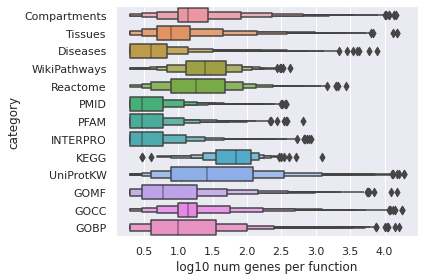

<Figure size 1440x432 with 0 Axes>

In [259]:
ax = sns.boxenplot(data=dfm, orient="h", x="log10 num genes per function", y="category")
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'figure.subplot.left': 0.1})
fn_out = r"/scratch/dblyon/agotool/data/PostgreSQL/tables/plots/Human2p_Boxenplot_Comparison_TextMining_vs_rest_log10_num_genes_per_function_v5.pdf"
plt.figure(figsize=(20, 6))
ax.get_figure().savefig(fn_out)

In [ ]:
from scipy import stats

In [ ]:
a = 5
b = 10
c = 10 
d = 20000
stats.fisher_exact([[a, b], [c, d]])

In [ ]:
### Debugging origin of functional association for given ENSP
# ENSP = "9606.ENSP00000340944"
# funcName = "GO:0016020" # membrane
# # PTPN11 (ENSP00000340944), is associated with a “Membrane” term with 3 stars.
# # original table 
# # original Score from Lars is 3.067649
# # backtracking needs to be fixed 
# cond = (df1["ENSP"] == ENSP) & (df1["funcName"] == funcName)
# df1[cond]

# df_22 = cst.rescale_scores(df1[df1["Etype"] == etype], alpha=alpha)
# df_22 = df_22[(df_22["Score"] >= 1.5) & (df_22["Rescaled_score"] <= beta)]

# # is any of these terms a child of "membrane"
# funcNames_2_check = sorted(df_22.loc[df_22["ENSP"] == ENSP, "funcName"].to_list())
# funcNames_2_check = [ele.replace("GOCC:", "GO:") for ele in funcNames_2_check]
# funcNames_2_check[:3]

# funcName = "GO:0016020" # membrane
# which_child_has_this_parent(funcNames_2_check, funcName, lineage_dict)

# # GO:0005785 has GO:0016020 as a parent
# # GO:0070618 has GO:0016020 as a parent
# l = ["GO:0070618", "GO:0005785"]
# cond = (df1["ENSP"] == ENSP) & (df1["funcName"].isin(l))
# df1[cond]

# # GO:0005785 has GO:0016020 as a parent
# # GO:0070618 has GO:0016020 as a parent
# l = ["GO:0070618", "GO:0005785", "GO:0016020"]
# cond = (df_22["funcName"].isin(l)) & (df_22["ENSP"] == ENSP)
# df_22[cond]

# etype = -22
# alpha = 0.325
# beta = 1.65
# df_22 = cst.rescale_scores(df1[df1["Etype"] == etype], alpha=alpha)
# l = ["GO:0070618", "GO:0005785", "GO:0016020"]
# ENSP = "9606.ENSP00000340944"
# cond = (df_22["funcName"].isin(l)) & (df_22["ENSP"] == ENSP)
# df_22[cond]

# l = ["GO:0070618", "GO:0005785", "GO:0016020"]
# ENSP = "9606.ENSP00000340944"
# df_22 = df_22[(df_22["Score"] >= 1.5) & (df_22["Rescaled_score"] <= beta)]
# df_22[cond]

# # GO:0005785 has GO:0016020 as a parent
# # GO:0070618 has GO:0016020 as a parent
# l = ["GOCC:0070618", "GOCC:0005785", "GOCC:0016020"]
# cond = (dft["funcName"].isin(l)) & (dft["ENSP"] == ENSP)
# dft[cond]